# Portfolio Optimization and Backtesting

In [1]:
# we import the necessary libraries that we will be using
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date

In [2]:
today = date.today().strftime('%Y-%m-%d')

# These are the tickers of the above stocks 
tickers = ['XOM', 'T', 'NOC', 'GLD', 'IBM', 'PG', 'VRTX', 'JNJ', 'KO', 'PM']

# We are going to be using the data of the past 2 years from the start of the backtesting to set weights to the stocks in portfolio
data = yf.download(tickers, start='2023-01-01', end='2025-05-11')['Close']
# convert to a pandas dataframe
df = pd.DataFrame(data)
df.dropna(axis=1, inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_13688\660560964.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2023-01-01', end='2025-05-11')['Close']
[*********************100%***********************]  10 of 10 completed


In [3]:
# Calculate daily returns of all the stocks for the lookbck period
returns = df.pct_change().dropna()
returns = returns*100

returns

Ticker,GLD,IBM,JNJ,KO,NOC,PG,PM,T,VRTX,XOM
Date,,,,,,,,,,
2023-01-04,0.941191,0.741793,1.088723,-0.047665,-2.568832,0.435428,-0.069113,2.134483,0.283196,0.291050
2023-01-05,-1.245146,-1.044905,-0.738373,-1.144294,0.393213,-1.241551,-0.405020,0.365717,0.369567,2.237408
2023-01-06,1.870750,1.835429,0.810985,1.929237,-1.343380,2.381296,2.648277,1.665813,0.805855,1.208683
2023-01-09,0.224512,-0.104345,-2.590867,-1.246045,-4.988297,-1.221412,-1.149867,-1.101192,-2.405148,-1.863744
2023-01-10,0.367604,0.870777,-0.239191,-0.766650,0.076702,-0.098660,-0.107528,2.258403,1.948942,1.493491
...,...,...,...,...,...,...,...,...,...,...
2025-05-05,2.986775,1.478314,-0.717393,0.069780,0.388666,-1.052830,1.363691,-0.362189,-0.191558,-2.768102
2025-05-06,2.802400,-0.024078,-0.341937,0.027895,-1.185810,0.264433,0.513886,2.362776,-10.028190,1.394402
2025-05-07,-1.499306,1.706000,1.832077,0.948135,-0.295396,0.025114,0.735293,-0.213066,-3.379773,-0.095498


In [4]:
expected_returns = returns.mean() * 252  # Annualized (252 trading days)
print("Expected Returns (Annualized):")
print(expected_returns)

Expected Returns (Annualized):
Ticker
GLD     26.166284
IBM     31.083296
JNJ     -1.740841
KO       8.863296
NOC     -0.507174
PG       5.693544
PM      28.957017
T       26.269343
VRTX    20.232029
XOM      6.333384
dtype: float64


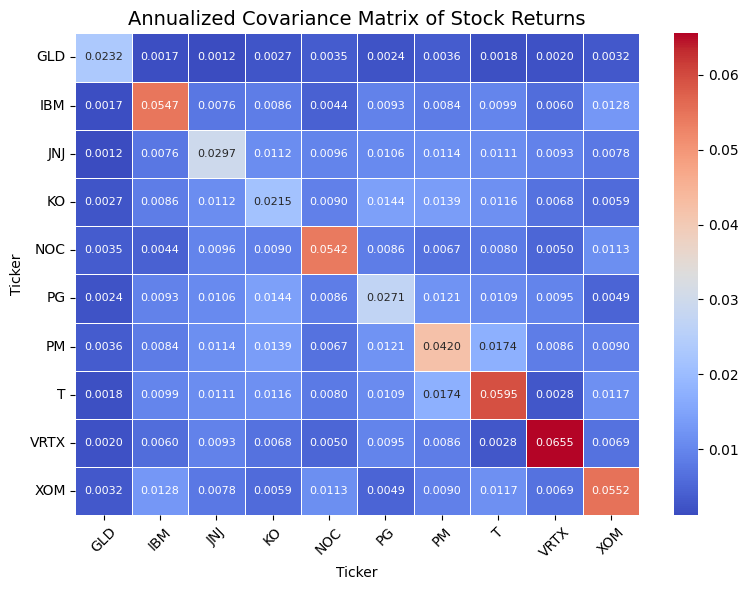

In [5]:
# Calculate returns and covariance matrix
cov_matrix = (returns/100).cov() * 252  # 6 year

# Create a heatmap to analyse the relations in stocks
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, 
            annot=True, 
            fmt=".4f", 
            cmap='coolwarm', 
            linewidths=.5, 
            annot_kws={"size": 8})
plt.title('Annualized Covariance Matrix of Stock Returns', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

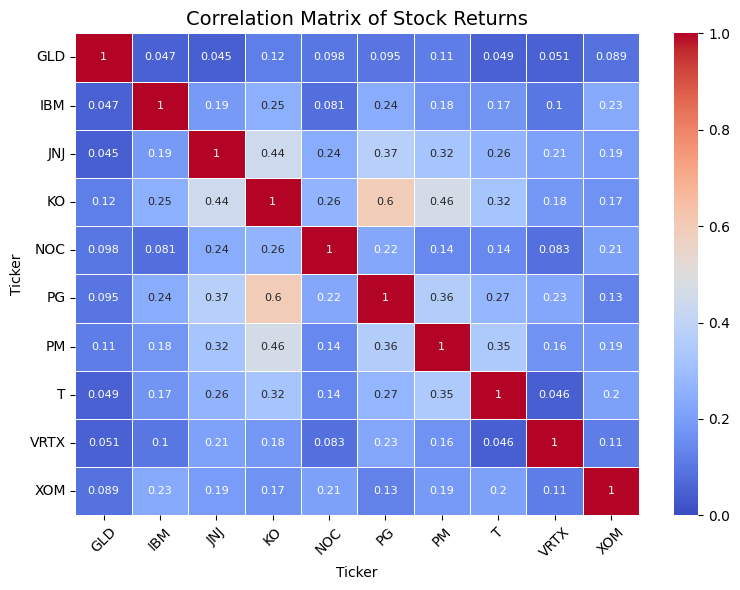

In [6]:
corr_matrix = returns.corr() # calculate the correlation of the returns of stocks
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=0, 
            vmax=1,
            linewidths=.5,
           annot_kws={"size": 8})
plt.title('Correlation Matrix of Stock Returns', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
# Number of stocks
num_stocks = len(data.columns)

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: Cap at 30% for each stock
bounds = tuple((0.05, 0.30) for stock in range(num_stocks))

# Objective Function: Negative Sharpe ratio
def sharpe_ratio(weights):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility  # Negative sharpe, because we want to maximize

# Initial Guess (equal weights)
# start from equal weights and then it will find the best weights to minimize the sharpe ratio
initial_weights = np.ones(num_stocks) / num_stocks

# Optimization
result = minimize(sharpe_ratio, initial_weights, constraints=constraints, bounds=bounds)

# Optimal Weights with Diversification Cap
optimal_weights = result.x

# Display Results
print("Optimal Weights in Percentage:")
print(optimal_weights)

Optimal Weights in Percentage:
[0.3        0.16962981 0.05       0.05       0.05       0.05
 0.14938796 0.07089727 0.06008495 0.05      ]


In [8]:
# Backtesting the strategy 
# download the data for the tickers for the past 2 years
start_date = '2023-04-01'
end_date = today


test_df = yf.download(tickers, start=start_date, end=end_date)['Close']

# download the data for the past 2 years for the S&P 500 so that we can compare our strategy with the performance of the market as whole
sp = yf.download("^GSPC", start=start_date, end=end_date)['Close']

# calculate the daily percentage changes of the stock and remove the empty row
test_df = test_df.pct_change().dropna()

# Calculate daily portfolio returns
ideal_weights = [0.025, 0.025, 0.025, 0.025, 0.4, 0.025, 0.025, 0.025, 0.025, 0.4]
# use ideal weights to compare if the weights assigned were good or not
portfolio_daily_returns = test_df.dot(ideal_weights)
portfolio_daily_returns2 = test_df.dot(optimal_weights)

# Calculate cumulative portfolio returns i.e. the returns on the $10,000 invested being monitored every session of trading 
portfolio_cumulative_returns = 10000*(1 + portfolio_daily_returns).cumprod()
portfolio_cumulative_returns2 = 10000*(1 + portfolio_daily_returns2).cumprod()

# Calculate daily S&P 500 returns
sp500_daily_returns = sp.pct_change()

# Calculate cumulative S&P 500 returns
sp500_cumulative_returns = 10000*(1 + sp500_daily_returns).cumprod()

C:\Users\admin\AppData\Local\Temp\ipykernel_13688\3151508558.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_df = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed
C:\Users\admin\AppData\Local\Temp\ipykernel_13688\3151508558.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


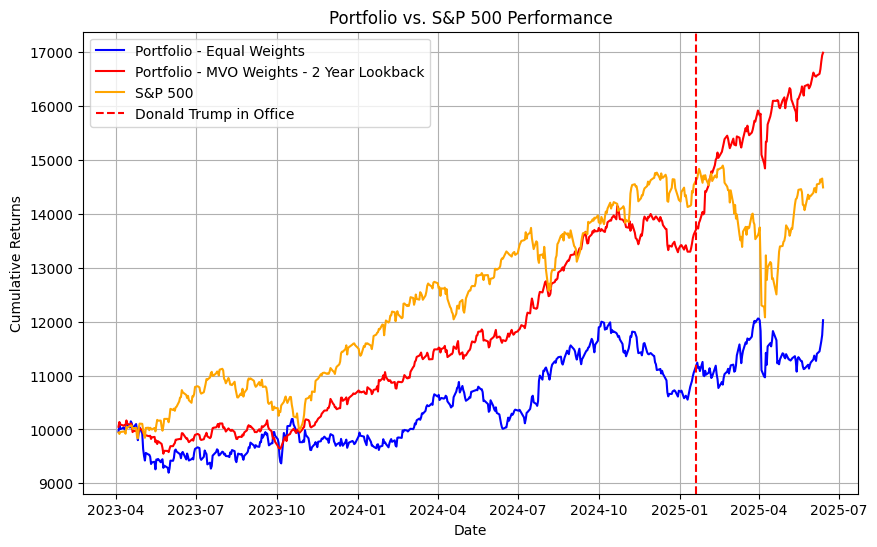

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns, label='Portfolio - Equal Weights', color='blue')
plt.plot(portfolio_cumulative_returns2, label='Portfolio - MVO Weights - 2 Year Lookback', color='red')
plt.plot(sp500_cumulative_returns, label='S&P 500', color='orange')
significant_event_date = pd.to_datetime("2025-01-20")
significant_event_date2 = pd.to_datetime("2025-04-03")
plt.axvline(x=significant_event_date, color='red', linestyle='--', linewidth=1.5, label='Donald Trump in Office')

# uncomment the next line to see the performance of the investments after donald trump imposed tariffs
# plt.axvline(x=significant_event_date2, color='black', linestyle='--', linewidth=1.5, label='Donald Trump imposes Tariffs')

plt.title('Portfolio vs. S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_13688\3141147861.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed
C:\Users\admin\AppData\Local\Temp\ipykernel_13688\3141147861.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hedge_prices = yf.download(hedge_ticker, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


Annualized Sharpe Ratio: 1.4356903566194992
Overall Return: 21.32%
Maximum Drawdown: -8.74%


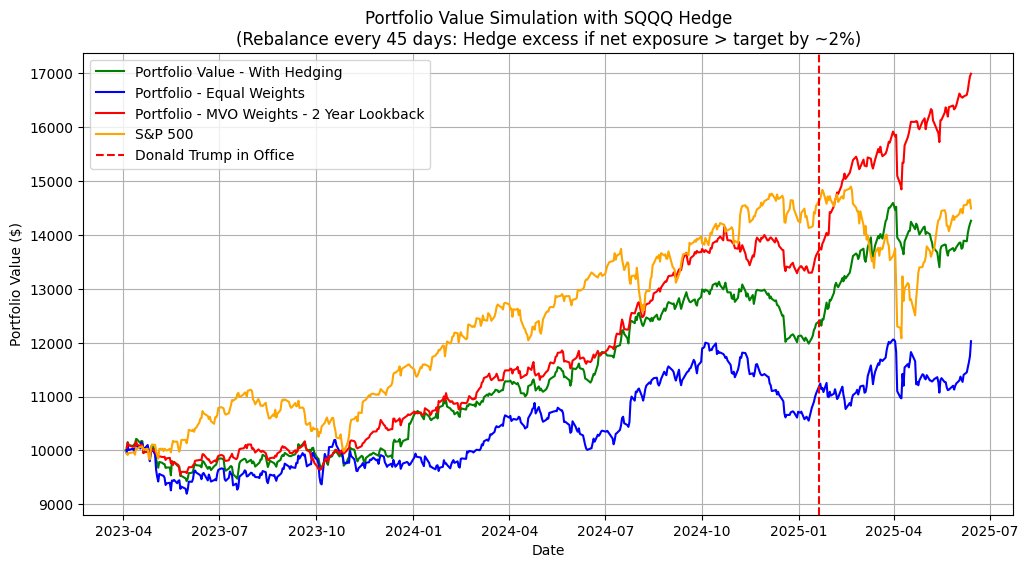

Final Effective Exposures (Net) as Percentage of Portfolio:
XOM: 21.94%
T: 18.39%
NOC: 4.01%
GLD: 6.01%
IBM: 6.36%
PG: 3.97%
VRTX: 14.67%
JNJ: 5.34%
KO: 5.13%
PM: 7.28%


In [10]:
# for hedging strategy i will be investing in the most popular inverse ETF ProShares UltraPro Short QQQ

hedge_ticker = 'SQQQ'  # inverse ETF ticker used for hedging
initial_capital = 10000.0
n = len(tickers) 
target_weights = pd.Series(optimal_weights, index=tickers) # starting weights remain same, we rebalance on them as we go on


# rebalancing settings
rebalance_interval_days = 45   # check every 45 calendar days, so as to trap momentum as well
threshold_fraction = 0.02        # if net exposure exceeds target by 2% of portfolio value, hedge the portfolio

# download daily close price data for the stocks
stock_prices = yf.download(tickers, start=start_date, end=end_date)['Close']
stock_prices.index = pd.to_datetime(stock_prices.index)

# download price data for the hedge ETF (SQQQ)
# Force hedge_prices to be a Series.
hedge_prices = yf.download(hedge_ticker, start=start_date, end=end_date)['Close']
hedge_prices = hedge_prices.squeeze()  # ensures it is a Series
hedge_prices.index = pd.to_datetime(hedge_prices.index)

# use the same trading dates (assumed to be the index of stock_prices)
all_dates = stock_prices.index


# for each stock, assign a dollar amount based on its target weight.
stock_positions = {ticker: target_weights[ticker] * initial_capital for ticker in tickers}
# for each stock, initially no hedge is in place (hedge positions will be in dollars of SQQQ)
hedge_positions = {ticker: 0.0 for ticker in tickers}

# build a list of rebalancing dates every 45 calendar days (snapped to the nearest trading day)
rebalance_dates = []
current_rb = pd.Timestamp(start_date)
while current_rb <= all_dates[-1]:
    idx = all_dates.get_indexer([current_rb], method='nearest')[0]
    rb_date = all_dates[idx]
    if not rebalance_dates or rb_date > rebalance_dates[-1]:
        rebalance_dates.append(rb_date)
    current_rb += pd.DateOffset(days=rebalance_interval_days)


# we will record daily portfolio value.
portfolio_value_series = pd.Series(index=all_dates, dtype=float)

# pointer for rebalancing dates.
rb_idx = 0
next_rb_date = rebalance_dates[rb_idx] if rebalance_dates else None

prev_day = all_dates[0]
for day in all_dates:
    # --- Update positions based on daily returns ---
    if day != prev_day:
        # Update each stock’s position by its daily return.
        for ticker in tickers:
            r = stock_prices.at[day, ticker] / stock_prices.at[prev_day, ticker] - 1
            stock_positions[ticker] *= (1 + r)
        # Update each hedge position using SQQQ's daily return.
        for ticker in tickers:
            r_hedge = hedge_prices.at[day] / hedge_prices.at[prev_day] - 1
            hedge_positions[ticker] *= (1 + r_hedge)
    
    # Compute total portfolio value as sum of (stock + hedge) for all tickers.
    portfolio_value = sum(stock_positions[t] + hedge_positions[t] for t in tickers)
    
    # --- Rebalancing on scheduled dates ---
    if next_rb_date is not None and day >= next_rb_date:
        for ticker in tickers:
            target_exposure = target_weights[ticker] * portfolio_value
            # Effective (net) exposure for this stock: stock dollars minus hedge dollars.
            effective_exposure = stock_positions[ticker] - hedge_positions[ticker]
            
            # If effective exposure is above target by more than threshold, hedge the excess.
            if effective_exposure > target_exposure + threshold_fraction * portfolio_value:
                excess = effective_exposure - target_exposure
                hedge_positions[ticker] += excess
            # Optionally, if effective exposure is below target and a hedge exists, unwind some hedge.
            elif effective_exposure < target_exposure - threshold_fraction * portfolio_value and hedge_positions[ticker] > 0:
                delta = target_exposure - effective_exposure
                hedge_positions[ticker] = max(0, hedge_positions[ticker] - delta)
        # Move to the next scheduled rebalancing date.
        rb_idx += 1
        if rb_idx < len(rebalance_dates):
            next_rb_date = rebalance_dates[rb_idx]
        else:
            next_rb_date = None
    
    portfolio_value_series.at[day] = portfolio_value
    prev_day = day

daily_returns = portfolio_value_series.pct_change().dropna()
annualized_sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

print("Annualized Sharpe Ratio:", annualized_sharpe)

initial_value = portfolio_value_series.iloc[0]
final_value = portfolio_value_series.iloc[-1]
overall_return = final_value / initial_value - 1

# Maximum Drawdown Calculation:
# 1. Compute the running maximum of the portfolio value.
running_max = portfolio_value_series.cummax()
# 2. Compute drawdown at each time point.
drawdowns = (portfolio_value_series - running_max) / running_max
# 3. The maximum drawdown is the minimum value in this series.
max_drawdown = drawdowns.min()

print("Overall Return: {:.2%}".format(overall_return/2))
print("Maximum Drawdown: {:.2%}".format(max_drawdown))

# plot the final results and see how the strategy performed
plt.figure(figsize=(12,6))
plt.plot(portfolio_value_series.index, portfolio_value_series, label="Portfolio Value - With Hedging", color='green')
plt.plot(portfolio_cumulative_returns, label='Portfolio - Equal Weights', color='blue')
plt.plot(portfolio_cumulative_returns2, label='Portfolio - MVO Weights - 2 Year Lookback', color='red')
plt.plot(sp500_cumulative_returns, label='S&P 500', color='orange')
plt.axvline(x=significant_event_date, color='red', linestyle='--', linewidth=1.5, label='Donald Trump in Office')
# uncomment the next line to see the rebalancing periods
# for d in rebalance_dates:
    # plt.axvline(x=d, color='black', linestyle='--', alpha=0.6)
plt.title("Portfolio Value Simulation with SQQQ Hedge\n(Rebalance every 45 days: Hedge excess if net exposure > target by ~2%)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()

# Print final effective exposures (net = stock - hedge) as a percentage of portfolio value.
print("Final Effective Exposures (Net) as Percentage of Portfolio:")
for ticker in tickers:
    effective_exposure = stock_positions[ticker] - hedge_positions[ticker]
    print(f"{ticker}: {effective_exposure / portfolio_value:.2%}")

Approximately 6.3% of the capital is allocated to the SQQQ, or in shorting the market. In these highly uncertain times it is better to hedge your position. 